<center><h1>Homework 1</h1></center>

In [1]:
import numpy as np
from matplotlib import pyplot as plt, text

1.

In [2]:
def adaptive_simps(f, x_i, x_f, accuracy):
    
    n = 10
    h = (x_f - x_i)/n
    x = np.arange(x_i, x_f, h)
    
    S = 1/3 * (f(x_i) + f(x_f) + 2 * np.sum(f(x[2::2])))
    T = 2/3 * np.sum(f(x[1::2]))
    F1 = h * (S + 2*T)
    
    for i in range(20):
        h /= 2
        x_odd = x + h
        S = S + T
        T = 2/3 * np.sum(f(x_odd))
        F2 = h * (S + 2*T)
        
        if abs(F1 - F2)/15 < accuracy:
            return F2
        
        x = np.vstack((x, x_odd)).flatten()
    
    return F2

def C_debye(Ndensity, V, thetaD, T, accuracy=0.001):
    k_B = 1.38e-23
    N = Ndensity * V
    prefactor = 9 * k_B * (T/thetaD)**3
    def f(x):
        etox = np.exp(x)
        return np.where(x != 0.0, x**4 * etox/(etox-1)**2, 0.0)
    integral = adaptive_simps(f, 0, thetaD/T, accuracy/prefactor)
    return N * prefactor * integral

<ipython-input-2-490aa737f1f9>:31: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(x != 0.0, x**4 * etox/(etox-1)**2, 0.0)
<ipython-input-2-490aa737f1f9>:31: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(x != 0.0, x**4 * etox/(etox-1)**2, 0.0)
<ipython-input-2-490aa737f1f9>:31: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(x != 0.0, x**4 * etox/(etox-1)**2, 0.0)


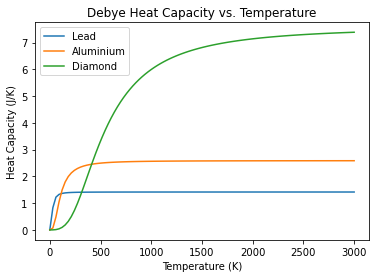

In [3]:
materials = [{'name': 'Lead', 'atomic mass': 207.2, 'density': 11.34, 'thetaD': 105},
             {'name': 'Aluminium', 'atomic mass': 27.0, 'density': 2.70, 'thetaD': 428},
             {'name': 'Diamond', 'atomic mass': 12.0, 'density': 3.52, 'thetaD': 2230}]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Debye Heat Capacity vs. Temperature')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Heat Capacity (J/K)')
for sample in materials:
    T = np.linspace(0.0, 3000.0, 100)
    C = [0]
    N_density = sample['density'] / (1.6 * sample['atomic mass']) * 1e24
    for i in range(1, 100):
        C.append(C_debye(N_density, 1.0, sample['thetaD'], T[i]))
    ax.plot(T, C, label=sample['name'])

ax.legend()

2. We have
$$\frac{dV_{out}}{dt} = \frac{1}{C}\frac{dQ}{dt}$$ and
$$V_{in} - V_{out} = R\frac{dQ}{dt}$$
Combining the two,
$$\frac{dV_{out}}{dt} = \frac{1}{RC}(V_{in} - V_{out})$$

In [4]:
def approx_rk4(dt, f, t0, x0, tf):
    
    t = t0
    x = x0
    x_list = [np.copy(x)]
    t_list = [t]
    
    n = int((tf - t0)/dt)
    for i in range(n):
        k1 = dt * f(x, t)
        k2 = dt * f(x + k1/2, t + dt/2)
        k3 = dt * f(x + k2/2, t + dt/2)
        k4 = dt * f(x + k3, t + dt)
        x += (k1 + 2*k2 + 2*k3 + k4)/6
        t += dt
        x_list.append(np.copy(x))
        t_list.append(t)
        
    return np.array(x_list), np.array(t_list)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


Text(0.5, 0.98, 'Output for square wave input')

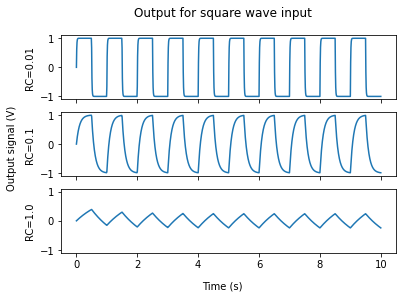

In [5]:
fig = plt.figure()

def square_wave(t):
    return -2 * int(t - int(t) + 0.5) + 1

RC = [0.01, 0.1, 1.0]
for i in range(3):
    def f(x, t):
        return (square_wave(t) - x)/RC[i]
    V, t = approx_rk4(0.01, f, 0.0, 0.0, 10.0)
    print(type(V[0]))
    ax = fig.add_subplot(311+i)
    ax.set_ylim(-1.1, 1.1)
    ax.set_ylabel('RC='+str(RC[i]))
    if i != 2:
        ax.set_xticklabels([])
    ax.plot(t, V)
xlabel = text.Text(0.45,0,'Time (s)')
ylabel = text.Text(0, 0.35, 'Output signal (V)', rotation='vertical')
fig.add_artist(xlabel)
fig.add_artist(ylabel)
fig.suptitle('Output for square wave input')

The output of the circuit smooths out the discontinuities in the input voltage. The higher the value of $RC$, the more smoothing occurs. When $V_{in}$ stays constant, $V_{out}$ gradually approaches the value of $V_{in}$ as the current in the circuit drops to zero. But when $V_{in}$ is changing quickly relative to the time constant $RC$, $V_{out}$ lags behind.

3.

In [6]:
def decay_solver(dt, N_A0, N_B0, tauA, tauB, tf):
    def f(x, t):
        matrix = np.array([[-1/tauA, 0],
                           [1/tauA, -1/tauB]])
        return np.matmul(matrix, x)
    
    return approx_rk4(dt, f, 0.0, np.array([N_A0, N_B0]), tf)

### Analytic Solution
$$\frac{dN_A}{dt} = -\frac{N_A}{\tau_A}$$
$$N_A(t) = N_A(0)e^{-t/\tau_A}$$

$\frac{dN_B}{dt} + \frac{N_B}{\tau_B} = \frac{N_A}{\tau_A}$ \
Multiplying both sides by $e^{t/\tau_B}$, \
$e^{t/\tau_B}\frac{dN_B}{dt} + \frac{e^{t/\tau_B}}{\tau_B}N_B = \frac{N_A}{\tau_A}$
$$\frac{d}{dt}(N_Be^{t/\tau_B}) = \frac{N_A}{\tau_A}$$
$$N_B(t) = N_B(0)e^{-t/\tau_B} + N_A(0)(1 - e^{-t/\tau_A})e^{-t/\tau_B}$$
$$= (N_B(0) - (N_A(t) - N_A(0)))e^{-t/\tau_B}$$

Cumulative Error:
A:  3.385875952006956e-09
B:  50039.16559955936


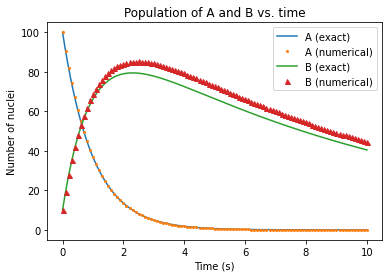

In [7]:
def cumulative_error(x1, x2):
    return np.sum(np.abs(x1-x2), axis=0)

N_A0 = 100.0
N_B0 = 10.0
tauA = 1.0
tauB = 10.0
approx, t = decay_solver(0.001, N_A0, N_B0, tauA, tauB, 10.0)
exactA = N_A0 * np.exp(-t/tauA)
exactB = (N_B0 - (exactA - N_A0)) * np.exp(-t/tauB)
exact = np.column_stack((exactA, exactB))

error = cumulative_error(approx, exact)
print('Cumulative Error:')
print('A: ', error[0])
print('B: ', error[1])
plt.plot(t, exactA, label='A (exact)')
plt.plot(t[::100], approx[::100,0], marker='o', markersize=2.0, linestyle='none', label='A (numerical)')
plt.plot(t, exactB, label='B (exact)')
plt.plot(t[::100], approx[::100,1], marker='^', markersize=5.0, linestyle='none', label='B (numerical)')
plt.xlabel('Time (s)')
plt.ylabel('Number of nuclei')
plt.title('Population of A and B vs. time')
plt.legend()

The approximation for nucleus type A is quite good since its decay does not depend on the amount of B present. However, type B has more complicated behavior. Although the numerical approximation usually captures the general behavior of the population of B, the cumulative error is quite significant (sometimes greater than 50000 with a timestep of 0.001s).

In all cases, the number of nuclei of each type decays to zero as time goes to infinity. When $\tau_A/\tau_B$ is large and we initially have comparable numbers of A and B, the population of B decreases rapidly because of the smaller decay constant (smaller half-life). However, B's curve then levels out and decays slower than A subsequently. When $\tau_A/\tau_B$ is small, the population of B either increases or remains stable, and then starts to fall again. This suggests the physical interpretation that nuclei of type A produce nuclei of type B when they decay. A large $\tau_A/\tau_B$ means A is decaying slowly, so the number of B nuclei produced is not enough to mitigate the rapid initial decay of B. When $\tau_A/\tau_B$ is small, A decays rapidly, stabilizing the population of B. However, as the A nuclei get depleted, the production of B also slows down and the decay of B takes over.

4.

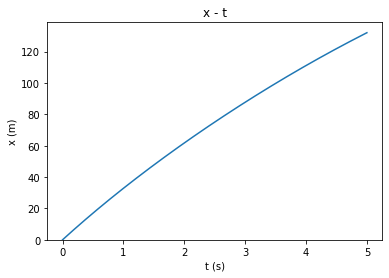

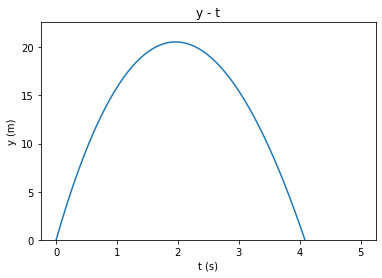

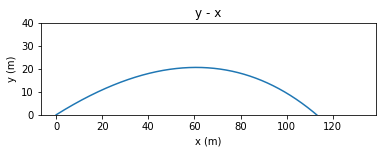

In [8]:
def baseball_solver(v0, theta):
    g = 9.8
    m = 0.15
    A = np.pi * 0.0352**2
    C = 0.3
    dt = 0.001
    
    dragConst = 0.5 * C * A / m 
    
    # s is a vector of the following form: [x, y, v_x, v_y]
    def f(s, t):
        [x, y, v_x, v_y] = np.copy(s)
        vmag = np.sqrt(v_x**2 + v_y**2)
        a_y = -g - dragConst * vmag * v_y
        a_x = -dragConst * vmag * v_x
        return np.array([v_x, v_y, a_x, a_y])
    
    initial = np.array([0., 0., v0 * np.cos(np.radians(theta)), v0 * np.sin(np.radians(theta))])
    sol, t = approx_rk4(dt, f, 0., initial, 5.)
    return sol, t

sol, t = baseball_solver(150.0 * 5/18, 32.0)
plt.plot(t, sol[:,0])
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.ylim(bottom=0.0)
plt.title('x - t')
plt.show()
plt.plot(t, sol[:,1])
plt.ylabel('y (m)')
plt.xlabel('t (s)')
plt.ylim(bottom=0.0)
plt.title('y - t')
plt.show()
fig = plt.figure()
ax = fig.get_axes()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
ax.set_ylim((0.0, 40.0))
ax.set_title('y - x')
ax.plot(sol[:,0], sol[:,1])

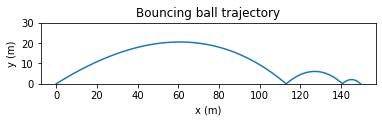

In [9]:
epsilon = 0.005
v0 = 150.0 * 5/18
theta = 32.0
x0 = 0.0
y0 = 0.0
data = []

for i in range(3):
    sol, t = baseball_solver(v0, theta)
    sol[:,0] += x0
    sol[:,1] += y0
    bounce = np.amin(np.argwhere(np.logical_and(sol[:,1] < epsilon, t > epsilon))[:,0])
    data.extend(sol[:bounce])
    [x0, y0, v_x, v_y] = sol[bounce]
    theta = -np.degrees(np.arctan2(v_y, v_x))
    v0 = 0.6 * np.sqrt(v_x**2 + v_y**2)

data = np.array(data)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_ylim((0.0, 30.0))
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Bouncing ball trajectory')
ax.plot(data[:,0], data[:,1])

E0:  130.20833333333331


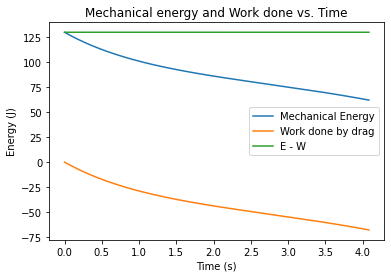

In [10]:
g = 9.8
m = 0.15
A = np.pi * 0.0352**2
C = 0.3
v0 = 150.0 * 5/18
theta = 32.0
sol, t = baseball_solver(v0, theta)
bounce = np.amin(np.argwhere(np.logical_and(sol[:,1] < epsilon, t > epsilon))[:,0])
t = t[:bounce-1]
r = sol[:bounce+1,:2]
v = sol[:bounce,2:4]
E = 1/2 * m * np.sum(v * v, axis=1) + m * g * r[:-1,1]
print('E0: ', E[0])
Fdrag = -1/2 * C * A * np.sqrt(np.sum(v * v, axis=1, keepdims=True)) * v
deltaR = r[1:] - r[:-1]
Wdrag = np.cumsum(np.sum(Fdrag * deltaR, axis=1))
plt.plot(t, E[1:], label='Mechanical Energy')
plt.plot(t, Wdrag[:-1], label='Work done by drag')
plt.plot(t, E[1:] - Wdrag[:-1], label='E - W')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.title('Mechanical energy and Work done vs. Time')
plt.legend()